### Convoluted Neural Network Image Classifier

This classifier was built based on a pre-trained network (MobileNetV2) to do image classification on the CIFAR-10 dataset. More information on the dataset is available here:  https://www.cs.toronto.edu/~kriz/cifar.html. For this classifier, I explore the use of transfer learning in the context of CNNs.

#### Import relevant packages

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import Model
from keras.applications import MobileNetV2
from keras.datasets import cifar10

import cv2

import sys
import numpy as np
import csv
import math

import matplotlib.pyplot as plt

print(tf.__version__)
print(keras.__version__)

2.18.0
3.9.0


### Import Dataset

In [2]:
# Class names for different classes
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer','dog', 'frog', 'horse', 'ship', 'truck']

# Load training data, labels; and testing data and their true labels
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()
print ('Training data size:', train_images.shape, 'Test data size', test_images.shape)

# Normalize pixel values between -1 and 1
train_images = train_images / 127.5 - 1
test_images = test_images / 127.5 - 1

Training data size: (50000, 32, 32, 3) Test data size (10000, 32, 32, 3)


### Visualize dataset

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

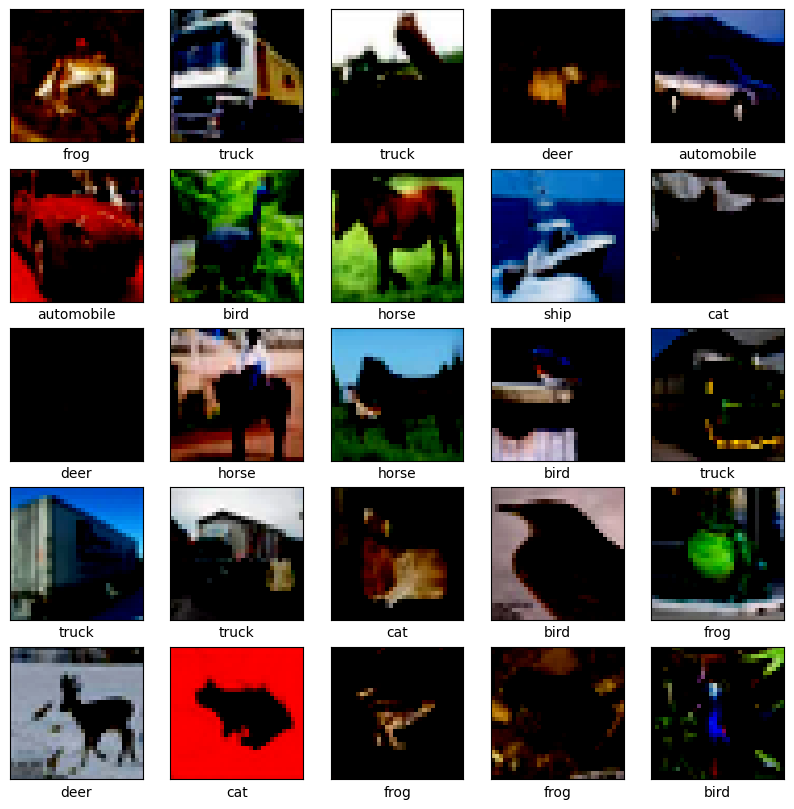

In [ ]:
%matplotlib inline
# Show first 25 training images below
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i][0]])

### Resize images for use with MobileNetV2

In [ ]:
# Upsize all training and testing images to 96x96 for use with mobile net
minSize = 96 #minimum size requried for mobileNetV2

# Resize train image
resized_train_images = np.zeros((50000, minSize, minSize, 3), dtype=np.float32)
for i in range(len(train_images)):
    resized_train_images[i] = cv2.resize(train_images[i], dsize=(minSize, minSize), interpolation=cv2.INTER_CUBIC)

# Resize test image
resized_test_images = np.zeros((10000, minSize, minSize, 3), dtype=np.float32)
for i in range(len(test_images)):
    resized_test_images[i] = cv2.resize(test_images[i], dsize=(minSize, minSize), interpolation=cv2.INTER_CUBIC)

# Print Resized Train and Test Image Size
print ('Resized Training data size:', resized_train_images.shape, 'Resized Test data size', resized_test_images.shape)

Resized Training data size: (50000, 96, 96, 3) Resized Test data size (10000, 96, 96, 3)


### Download MobileNetV2 model



In [ ]:
# Load pre-trained MobileNetV2 model (without top layers)
base_model = tf.keras.applications.MobileNetV2(
    include_top=False,
    weights='imagenet',
    input_shape=(96, 96, 3))

# Freeze the base model layers (to retain the pre-trained weights)
base_model.trainable = False

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [6]:
base_model.summary()

Model: "mobilenetv2_1.00_96"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 96, 96, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 48, 48,    │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 48, 48,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 48, 48,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 48, 48,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 48, 48,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 48, 48,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 48, 48,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 48, 48,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 48, 48,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 48, 48,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 48, 48,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 49, 49,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 24, 24,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 24, 24,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 24, 24,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 24, 24,    │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

### Add custom layers at the end of downloaded model

In [ ]:
# Add custom layers
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(128, activation="relu")(x)
x = tf.keras.layers.Dense(64, activation="relu")(x)
x = tf.keras.layers.Dropout(0.3)(x)
outputs = tf.keras.layers.Dense(10, activation='softmax')(x)

final_model = tf.keras.models.Model(inputs=base_model.input, outputs=outputs)

In [8]:
final_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 96, 96, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 48, 48,    │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 48, 48,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 48, 48,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 48, 48,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 48, 48,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 48, 48,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 48, 48,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 48, 48,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 48, 48,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 48, 48,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 48, 48,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 49, 49,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 24, 24,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 24, 24,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 24, 24,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 24, 24,    │      2,304 │ block_1_depthwis

 Total params: 2,435,978 (9.29 MB)

 Trainable params: 175,434 (685.29 KB)

 Non-trainable params: 2,260,544 (8.62 MB)

### Add loss function, compile and train the model, and check accuracy on test data

In [9]:
# Check for Existence of GPUs
print("Number of GPUs Available:", len(tf.config.list_physical_devices('GPU')))

Number of GPUs Available: 0


In [ ]:
# Compile Model
base_learning_rate = 0.0001
final_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train Model for specified epochs until the indicated termination condition
epochs = 30
batch_size = 32
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                                  patience=5,
                                                  min_delta=0.0001,
                                                  restore_best_weights=True)
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath='checkpoint.weights.h5',
                                                save_weights_only=True,
                                                save_freq=1000) # saves after every 1000 batches
history = final_model.fit(resized_train_images,
                          train_labels,
                          batch_size=batch_size,
                          epochs=epochs,
                          callbacks=[early_stopping, checkpoint],
                          validation_data=(resized_test_images, test_labels))

Epoch 1/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 461s 277ms/step - accuracy: 0.5429 - loss: 1.3859 - val_accuracy: 0.8245 - val_loss: 0.5229
Epoch 2/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 425s 272ms/step - accuracy: 0.8083 - loss: 0.5920 - val_accuracy: 0.8465 - val_loss: 0.4624
Epoch 3/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 300s 192ms/step - accuracy: 0.8355 - loss: 0.4940 - val_accuracy: 0.8538 - val_loss: 0.4372
Epoch 4/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 299s 191ms/step - accuracy: 0.8491 - loss: 0.4450 - val_accuracy: 0.8576 - val_loss: 0.4253
Epoch 5/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 265s 170ms/step - accuracy: 0.8632 - loss: 0.4020 - val_accuracy: 0.8605 - val_loss: 0.4173
Epoch 6/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 270s 173ms/step - accuracy: 0.8731 - loss: 0.3811 - val_accuracy: 0.8602 - val_loss: 0.4103
Epoch 7/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 257s 165ms/step - accuracy: 0.8764 - loss: 0.3574 - val_accuracy: 0.8652 - val_loss: 0.4059
Epoch 8/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 256s 164ms/step - ac

### Generate plot for training loss

[0.9609482288360596, 0.5721919536590576, 0.4915739595890045, 0.4424816071987152, 0.4054976999759674, 0.38402801752090454, 0.3597387969493866, 0.3395712077617645, 0.32221561670303345, 0.3046538233757019, 0.2873566150665283, 0.27452385425567627, 0.26256000995635986, 0.2518848776817322, 0.23750406503677368, 0.22556577622890472]


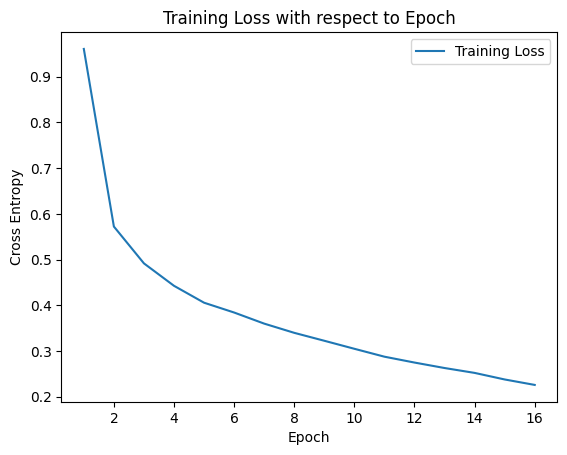

In [13]:
# Training Loss
loss = history.history['loss']
print(loss)

# Plotting Training Loss with Respect to the number of Epochs
plt.plot(range(1, len(loss)+1), loss, label='Training Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training Loss with respect to Epoch')
plt.xlabel('Epoch')
plt.show()

### Accuracy of the Trained Classifier

In [15]:
test_loss, test_acc = final_model.evaluate(resized_test_images, test_labels)
print('Test Accuracy:', test_acc)

313/313 ━━━━━━━━━━━━━━━━━━━━ 33s 106ms/step - accuracy: 0.8694 - loss: 0.4020
Test Accuracy: 0.8658000230789185
